In [ ]:
import os
from google.colab import  drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/mode/

/content/drive/MyDrive/mode


In [ ]:
# !pip install pyclipper shapely 
!pip install imgaug==0.4.0 pyclipper shapely


In [ ]:
# 统一导入工具包
import os
import warnings
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import cv2
import math
import pyclipper
import imgaug
import imgaug.augmenters as iaa

from PIL import Image
from shapely.geometry import Polygon
from collections import OrderedDict
from tqdm import tqdm
from torchvision import transforms

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# 是否使用 GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    

In [ ]:
# 参数设置
class DetOptions():
    def __init__(self):
        self.lr = 0.004
        self.max_epoch =100
        self.batch_size = 8
        self.num_workers = 8
        self.print_interval = 100
        self.save_interval = 100
        self.train_dir = 'datasets/data/train_imgs'
        self.train_gt_dir = 'datasets/data/train_gts'                 
        self.test_dir = 'datasets/data/test_imgs'
        self.save_dir = 'temp/det_models/'                            # 保存检测模型
        self.saved_model_path = 'temp/det_models/checkpoint_final'    # 保存最终检测模型
        self.det_res_dir = 'temp/det_res/'                            # 保存测试集检测结
        self.thresh = 0.3                                             # 分割后处理阈值
        self.box_thresh = 0.5                                         # 检测框阈值
        self.max_candidates = 10                                      # 候选检测框数量（本数据集每张图像只有一个文本，因此可置为1）
        self.test_img_short_side = 640                                # 测试图像最短边长度

det_args = DetOptions()



In [ ]:
'''
数据增强变换方法
'''
class BaseAugment():
    '''
    通过 imgaug.augmenters 进行基础变换，包括尺寸调整、翻转、旋转等
    '''
    def __init__(self, only_resize=False, keep_ratio=False, augmenters=None, resize_shape=None):
        self.only_resize = only_resize
        self.keep_ratio = keep_ratio
        self.augmenter = augmenters
        self.resize_shape = resize_shape

    def resize_image(self, image):
        origin_height, origin_width, _ = image.shape
        height = self.resize_shape['height']
        width = self.resize_shape['width']
        if self.keep_ratio:    # 是否保持图像长宽比不变
            width = origin_width * height / origin_height
            N = math.ceil(width / 32)
            width = N * 32
        image = cv2.resize(image, (width, height))
        return image
    
    def process(self, data):
        image = data['image']
        shape = image.shape

        if self.augmenter:
            aug = self.augmenter.to_deterministic()
            if self.only_resize:
                data['image'] = self.resize_image(image)   # 只进行尺寸调整
            else:
                data['image'] = aug.augment_image(image)   # 图像变换
            self.may_augment_annotation(aug, data, shape)  # 对 polygon 标注进行对应的变换

        filename = data.get('filename', data.get('data_id', ''))
        data.update(filename=filename, shape=shape[:2])
        return data
        
    def may_augment_annotation(self, aug, data, shape):
        if aug is None:
            return data

        line_polys = []
        for line in data['lines']:
            if self.only_resize:
                new_poly = [(p[0], p[1]) for p in line['poly']]
            else:
                new_poly = self.may_augment_poly(aug, shape, line['poly'])
            line_polys.append({
                'points': new_poly,
                'ignore': line['text'] == '###',    # 图像是否是困难样本（模糊不可辨），本任务数据集中不存在困难样本
                'text': line['text'],
            })
        data['polys'] = line_polys
        return data

    def may_augment_poly(self, aug, img_shape, poly):
        keypoints = [imgaug.Keypoint(p[0], p[1]) for p in poly]
        keypoints = aug.augment_keypoints([imgaug.KeypointsOnImage(keypoints, shape=img_shape)])[0].keypoints
        poly = [(p.x, p.y) for p in keypoints]
        return poly
    
    
class ColorJitter():
    '''
    颜色增强，包括亮度、对比度、饱和度、色相变换
    '''
    def __init__(self, b=0.2, c=0.2, s=0.15, h=0.15):
        self.color_jitter = torchvision.transforms.ColorJitter(
            brightness=b, contrast=c, saturation=s, hue=h)
    def process(self, data):
        img = data['image']
        image = Image.fromarray(img.astype('uint8')).convert('RGB')   # 数据类型转换
        img = np.array(self.color_jitter(image)).astype(np.float64)
        data['image'] = img
        return data
    

class RandomCropData():
    '''
    随机裁剪图像，并保证裁剪时不切割到图像中的文字区域
    '''
    def __init__(self, size=(640, 640)):
        self.size = size
        self.max_tries = 10             # 裁剪尝试的最大次数（因为存在裁剪区域太小等裁剪失败情况）
        self.min_crop_side_ratio = 0.1  # 裁剪区域边长最小比例，即裁剪的图像边长与原始图像边长的比值不能小于 min_crop_side_ratio
        
    def process(self, data):
        img = data['image']

        ori_img = img
        ori_lines = data['polys']
        all_care_polys = [line['points'] for line in data['polys'] if not line['ignore']]
        crop_x, crop_y, crop_w, crop_h = self.crop_area(img, all_care_polys)   # 裁剪区域的左上角坐标(x, y)以及区域宽高(w, h)
        
        # 根据裁剪区域参数对图像进行裁剪，并填充空白以得到指定 size 的图像（在右侧或者底侧进行填充）
        scale_w = self.size[0] / crop_w
        scale_h = self.size[1] / crop_h
        scale = min(scale_w, scale_h)
        h = int(crop_h * scale)
        w = int(crop_w * scale)
        padimg = np.zeros((self.size[1], self.size[0], img.shape[2]), img.dtype)
        padimg[:h, :w] = cv2.resize(img[crop_y:crop_y + crop_h, crop_x:crop_x + crop_w], (w, h))
        img = padimg
        
        # 根据裁剪区域参数对文字位置坐标进行转换
        lines = []
        for line in data['polys']:
            poly = ((np.array(line['points']) - (crop_x, crop_y)) * scale).tolist()
            if not self.is_poly_outside_rect(poly, 0, 0, w, h): lines.append({**line, 'points': poly}) # 不保留裁剪区域之外的文字
        
        data['polys'] = lines
        data['image'] = img

        return data


    def is_poly_outside_rect(self, poly, x, y, w, h):
        # 判断文字polygon 是否在矩形区域外
        poly = np.array(poly)
        if poly[:, 0].max() < x or poly[:, 0].min() > x + w:
            return True
        if poly[:, 1].max() < y or poly[:, 1].min() > y + h:
            return True
        return False

    def split_regions(self, axis):
        # 返回可划切割线的连续区域
        regions = []
        min_axis = 0
        for i in range(1, axis.shape[0]):
            if axis[i] != axis[i-1] + 1:
                region = axis[min_axis:i]
                min_axis = i
                regions.append(region)
        return regions

    def random_select(self, axis, max_size):
        # 从一块连续区域中选择两条切割线
        xx = np.random.choice(axis, size=2)
        xmin = np.min(xx)
        xmax = np.max(xx)
        xmin = np.clip(xmin, 0, max_size - 1)
        xmax = np.clip(xmax, 0, max_size - 1)
        return xmin, xmax

    def region_wise_random_select(self, regions, max_size):
        # 从两块连续区域中选择两条切割线
        selected_index = list(np.random.choice(len(regions), 2))
        selected_values = []
        for index in selected_index:
            axis = regions[index]
            xx = int(np.random.choice(axis, size=1))
            selected_values.append(xx)
        xmin = min(selected_values)
        xmax = max(selected_values)
        return xmin, xmax

    def crop_area(self, img, polys):
        # 裁剪区域
        h, w, _ = img.shape
        h_array = np.zeros(h, dtype=np.int32)
        w_array = np.zeros(w, dtype=np.int32)
        for points in polys:
            points = np.round(points, decimals=0).astype(np.int32)
            minx = np.min(points[:, 0])
            maxx = np.max(points[:, 0])
            w_array[minx:maxx] = 1
            miny = np.min(points[:, 1])
            maxy = np.max(points[:, 1])
            h_array[miny:maxy] = 1
        # h_array == 1 的位置表示有文本，h_array == 0 的位置表示无文本；w_array 同理
        h_axis = np.where(h_array == 0)[0]
        w_axis = np.where(w_array == 0)[0]

        if len(h_axis) == 0 or len(w_axis) == 0:
            return 0, 0, w, h

        h_regions = self.split_regions(h_axis)
        w_regions = self.split_regions(w_axis)

        for i in range(self.max_tries):
            if len(w_regions) > 1:
                # 有多块可切割区域时
                xmin, xmax = self.region_wise_random_select(w_regions, w)
            else:
                # 只有一块可切割区域时
                xmin, xmax = self.random_select(w_axis, w)
            if len(h_regions) > 1:
                ymin, ymax = self.region_wise_random_select(h_regions, h)
            else:
                ymin, ymax = self.random_select(h_axis, h)

            if xmax - xmin < self.min_crop_side_ratio * w or ymax - ymin < self.min_crop_side_ratio * h:
                # 切割区域太小，不可取
                continue
            num_poly_in_rect = 0
            
            # 保证至少有一个文字区域在切割出的区域中即可
            for poly in polys:
                if not self.is_poly_outside_rect(poly, xmin, ymin, xmax - xmin, ymax - ymin):
                    num_poly_in_rect += 1
                    break

            if num_poly_in_rect > 0:
                return xmin, ymin, xmax - xmin, ymax - ymin

        return 0, 0, w, h
    


class MakeSegDetectionData():
    '''
    构造文本区域二值图（DB论文中的 probability map），以及用于计算loss的mask
    '''
    def __init__(self, min_text_size=8, shrink_ratio=0.4):
        self.min_text_size = min_text_size
        self.shrink_ratio = shrink_ratio      # polygon 收缩比例

    def process(self, data):
        # 数据结构调整统一，方便后续操作
        polygons = []
        ignore_tags = []
        annotations = data['polys']
        for annotation in annotations:
            polygons.append(np.array(annotation['points']))
            ignore_tags.append(annotation['ignore'])
        ignore_tags = np.array(ignore_tags, dtype=np.uint8)
        filename = data.get('filename', data['data_id'])
        shape = np.array(data['shape'])
        data = OrderedDict(image=data['image'],
                           polygons=polygons,
                           ignore_tags=ignore_tags,
                           shape=shape,
                           filename=filename,
                           is_training=data['is_training'])
    
        image = data['image']
        polygons = data['polygons']
        ignore_tags = data['ignore_tags']
        image = data['image']
        filename = data['filename']

        h, w = image.shape[:2]
        if data['is_training']:
            polygons, ignore_tags = self.validate_polygons(polygons, ignore_tags, h, w)
        gt = np.zeros((h, w), dtype=np.float32)
        mask = np.ones((h, w), dtype=np.float32)
        for i in range(len(polygons)):
            polygon = polygons[i]
            height = max(polygon[:, 1]) - min(polygon[:, 1])
            width = max(polygon[:, 0]) - min(polygon[:, 0])
            if ignore_tags[i] or min(height, width) < self.min_text_size: # 文本区域太小时，作为困难样本 ignore
                cv2.fillPoly(mask, polygon.astype(np.int32)[np.newaxis, :, :], 0)
                ignore_tags[i] = True
            else:
                # 收缩 polygon 并绘制 probability map
                polygon_shape = Polygon(polygon)
                distance = polygon_shape.area * (1 - np.power(self.shrink_ratio, 2)) / polygon_shape.length
                subject = [tuple(l) for l in polygons[i]]
                padding = pyclipper.PyclipperOffset()
                padding.AddPath(subject, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
                shrinked = padding.Execute(-distance)
                if shrinked == []:
                    cv2.fillPoly(mask, polygon.astype(np.int32)[np.newaxis, :, :], 0)
                    ignore_tags[i] = True
                    continue
                shrinked = np.array(shrinked[0]).reshape(-1, 2)
                cv2.fillPoly(gt, [shrinked.astype(np.int32)], 1)

        if filename is None:
            filename = ''
        data.update(image=image,
                    polygons=polygons,
                    gt=gt, mask=mask, filename=filename)
        return data

    
    def validate_polygons(self, polygons, ignore_tags, h, w):
        '''
        统一polygon坐标顺序，并且ignore面积为0的polygons
        '''
        if len(polygons) == 0:
            return polygons, ignore_tags
        assert len(polygons) == len(ignore_tags)
        for polygon in polygons:
            polygon[:, 0] = np.clip(polygon[:, 0], 0, w - 1)
            polygon[:, 1] = np.clip(polygon[:, 1], 0, h - 1)

        for i in range(len(polygons)):
            area = self.polygon_area(polygons[i])
            if abs(area) < 1:
                ignore_tags[i] = True
            if area > 0:
                polygons[i] = polygons[i][::-1, :]   # 调整坐标顺序
        return polygons, ignore_tags

    def polygon_area(self, polygon):
        edge = 0
        for i in range(polygon.shape[0]):
            next_index = (i + 1) % polygon.shape[0]
            edge += (polygon[next_index, 0] - polygon[i, 0]) * (polygon[next_index, 1] + polygon[i, 1])

        return edge / 2.



class MakeBorderMap():
    '''
    构造文本边界二值图（DB论文中的 threshold map），以及用于计算loss的mask
    '''
    def __init__(self, shrink_ratio=0.4, thresh_min=0.3, thresh_max=0.7):
        self.shrink_ratio = shrink_ratio
        self.thresh_min = thresh_min
        self.thresh_max = thresh_max
        warnings.simplefilter("ignore")

    def process(self, data):
        image = data['image']
        polygons = data['polygons']
        ignore_tags = data['ignore_tags']
        canvas = np.zeros(image.shape[:2], dtype=np.float32)
        mask = np.zeros(image.shape[:2], dtype=np.float32)

        for i in range(len(polygons)):
            if ignore_tags[i]:
                continue
            self.draw_border_map(polygons[i], canvas, mask=mask)    # 绘制 border map
        canvas = canvas * (self.thresh_max - self.thresh_min) + self.thresh_min
        data['thresh_map'] = canvas
        data['thresh_mask'] = mask
        return data

    def draw_border_map(self, polygon, canvas, mask):
        polygon = np.array(polygon)
        assert polygon.ndim == 2
        assert polygon.shape[1] == 2

        polygon_shape = Polygon(polygon)
        distance = polygon_shape.area * (1 - np.power(self.shrink_ratio, 2)) / polygon_shape.length
        subject = [tuple(l) for l in polygon]
        padding = pyclipper.PyclipperOffset()
        padding.AddPath(subject, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        padded_polygon = np.array(padding.Execute(distance)[0])
        cv2.fillPoly(mask, [padded_polygon.astype(np.int32)], 1.0)

        xmin = padded_polygon[:, 0].min()
        xmax = padded_polygon[:, 0].max()
        ymin = padded_polygon[:, 1].min()
        ymax = padded_polygon[:, 1].max()
        width = xmax - xmin + 1
        height = ymax - ymin + 1

        polygon[:, 0] = polygon[:, 0] - xmin
        polygon[:, 1] = polygon[:, 1] - ymin

        xs = np.broadcast_to(np.linspace(0, width - 1, num=width).reshape(1, width), (height, width))
        ys = np.broadcast_to(np.linspace(0, height - 1, num=height).reshape(height, 1), (height, width))

        distance_map = np.zeros((polygon.shape[0], height, width), dtype=np.float32)
        for i in range(polygon.shape[0]):
            j = (i + 1) % polygon.shape[0]
            absolute_distance = self.distance(xs, ys, polygon[i], polygon[j])
            distance_map[i] = np.clip(absolute_distance / distance, 0, 1)
        distance_map = distance_map.min(axis=0)

        xmin_valid = min(max(0, xmin), canvas.shape[1] - 1)
        xmax_valid = min(max(0, xmax), canvas.shape[1] - 1)
        ymin_valid = min(max(0, ymin), canvas.shape[0] - 1)
        ymax_valid = min(max(0, ymax), canvas.shape[0] - 1)
        canvas[ymin_valid:ymax_valid + 1, xmin_valid:xmax_valid + 1] = np.fmax(
            1 - distance_map[
                ymin_valid-ymin:ymax_valid-ymax+height,
                xmin_valid-xmin:xmax_valid-xmax+width],
            canvas[ymin_valid:ymax_valid + 1, xmin_valid:xmax_valid + 1])

    def distance(self, xs, ys, point_1, point_2):
        # 计算图像中的点到 文字polygon 边界的距离
        height, width = xs.shape[:2]
        square_distance_1 = np.square(
            xs - point_1[0]) + np.square(ys - point_1[1])
        square_distance_2 = np.square(
            xs - point_2[0]) + np.square(ys - point_2[1])
        square_distance = np.square(
            point_1[0] - point_2[0]) + np.square(point_1[1] - point_2[1])

        cosin = (square_distance - square_distance_1 - square_distance_2) / (2 * np.sqrt(square_distance_1 * square_distance_2))
        square_sin = 1 - np.square(cosin)
        square_sin = np.nan_to_num(square_sin)
        result = np.sqrt(square_distance_1 * square_distance_2 * square_sin / square_distance)

        result[cosin < 0] = np.sqrt(np.fmin(square_distance_1, square_distance_2))[cosin < 0]
        return result

    
class NormalizeImage():
    '''
    将图像元素值归一化到[-1, 1]
    '''
    RGB_MEAN = np.array([122.67891434, 116.66876762, 104.00698793])

    def process(self, data):
        assert 'image' in data, '`image` in data is required by this process'
        image = data['image']
        image -= self.RGB_MEAN
        image /= 255.
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        data['image'] = image
        return data
    
    @classmethod
    def restore(self, image):
        image = image.permute(1, 2, 0).to('cpu').numpy()
        image = image * 255.
        image += self.RGB_MEAN
        image = image.astype(np.uint8)
        return image
    
    
class FilterKeys():
    '''
    过滤掉后续不需要的键值对
    '''
    def __init__(self, superfluous):
        self.superfluous_keys = set(superfluous)
        
    def process(self, data):
        for key in self.superfluous_keys:
            del data[key]
        return data


# 训练集数据处理
train_processes = [             
    BaseAugment(only_resize=False, keep_ratio=False, 
        augmenters=iaa.Sequential([
            iaa.Fliplr(0.5),               # 水平翻转
            iaa.Affine(rotate=(-10, 10)),  # 旋转
            iaa.Resize((0.5, 3.0))         # 尺寸调整
        ])),
    ColorJitter(),                         # 颜色增强
    RandomCropData(size=[640, 640]),       # 随机裁剪
    MakeSegDetectionData(),                # 构造 probability map
    MakeBorderMap(),                       # 构造 threshold map
    NormalizeImage(),                      # 归一化
    FilterKeys(superfluous=['polygons', 'filename', 'shape', 'ignore_tags', 'is_training']),    # 过滤多余元素
]


'''
数据集导入方法
'''
# dataset
class ImageDataset(data.Dataset):
    def __init__(self, data_dir=None, gt_dir=None, is_training=True, processes=None):
        self.data_dir = data_dir
        self.gt_dir = gt_dir
        self.is_training = is_training
        self.processes = processes

        self.image_paths = []
        self.gt_paths = []

        image_list = os.listdir(self.data_dir)
        self.image_paths = [self.data_dir + '/' + t for t in image_list]
        self.gt_paths = [self.gt_dir + '/' + t.replace('.jpg', '.txt') for t in image_list]
        self.targets = self.load_ann()      # 导入标注信息

    def load_ann(self):
        res = []
        for gt in self.gt_paths:
            lines = []
            reader = open(gt, 'r').readlines()
            for line in reader:
                item = {}
                line = line.strip().split()
                poly = np.array(list(map(float, line[:8]))).reshape((-1, 2)).tolist()
                item['poly'] = poly
                item['text'] = line[8]   # 前8为 polygon 坐标，第9是文本字符串
                lines.append(item)
            res.append(lines)
        return res

    def __getitem__(self, index):
        if index >= len(self.image_paths):
            index = index % len(self.image_paths)
        data = {}
        image_path = self.image_paths[index]
        
        img = cv2.imread(image_path, cv2.IMREAD_COLOR).astype('float32')
        target = self.targets[index]
        
        data['filename'] = image_path.split('/')[-1]
        data['data_id'] = image_path.split('/')[-1]
        data['image'] = img
        data['lines'] = target
        data['is_training'] = self.is_training
        if self.processes is not None:
            for data_process in self.processes:    # 做数据增强
                data = data_process.process(data)
        return data

    def __len__(self):
        return len(self.image_paths)

In [ ]:
# BCE loss 计算 probability map 损失
class BalanceCrossEntropyLoss(nn.Module):
    def __init__(self, negative_ratio=3.0, eps=1e-6):
        super(BalanceCrossEntropyLoss, self).__init__()
        self.negative_ratio = negative_ratio
        self.eps = eps

    def forward(self, pred, gt, mask):
        if pred.dim() == 4:
            pred = pred[:, 0, :, :]
        positive = (gt * mask).byte()
        negative = ((1 - gt) * mask).byte()
        positive_count = int(positive.float().sum())
        negative_count = min(int(negative.float().sum()), int(positive_count * self.negative_ratio))
        loss = nn.functional.binary_cross_entropy(pred, gt, reduction='none')
        positive_loss = loss * positive.float()
        negative_loss = loss * negative.float()
        negative_loss, _ = torch.topk(negative_loss.view(-1), negative_count)

        balance_loss = (positive_loss.sum() + negative_loss.sum()) / (positive_count + negative_count + self.eps)
        return balance_loss


# MaskL1Loss 计算 threshold map 损失
class MaskL1Loss(nn.Module):
    def __init__(self):
        super(MaskL1Loss, self).__init__()

    def forward(self, pred, gt, mask):
        mask_sum = mask.sum()
        if mask_sum.item() == 0:
            return mask_sum
        else:
            loss = (torch.abs(pred[:, 0] - gt) * mask).sum() / mask_sum
            return loss


# DiceLoss 计算 approximate binary map 损失
class DiceLoss(nn.Module):
    '''
    Loss function from https://arxiv.org/abs/1707.03237
    '''
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, pred, gt, mask):
        if pred.dim() == 4:
            pred = pred[:, 0, :, :]
        assert pred.shape == gt.shape
        assert pred.shape == mask.shape

        intersection = (pred * gt * mask).sum()
        union = (pred * mask).sum() + (gt * mask).sum() + self.eps
        loss = 1 - 2.0 * intersection / union
        return loss
    

class L1BalanceCELoss(nn.Module):
    def __init__(self, eps=1e-6, l1_scale=10, bce_scale=1):
        super(L1BalanceCELoss, self).__init__()
        self.dice_loss = DiceLoss(eps=eps)
        self.l1_loss = MaskL1Loss()
        self.bce_loss = BalanceCrossEntropyLoss()

        self.l1_scale = l1_scale        # 不同损失赋予不同权重
        self.bce_scale = bce_scale

    def forward(self, pred, batch):
        metrics = dict()
        bce_loss = self.bce_loss(pred['binary'], batch['gt'], batch['mask'])
        l1_loss = self.l1_loss(pred['thresh'], batch['thresh_map'], batch['thresh_mask'])
        dice_loss = self.dice_loss(pred['thresh_binary'], batch['gt'], batch['mask'])
        
        loss = dice_loss + self.l1_scale * l1_loss + bce_loss * self.bce_scale    
        metrics['binary_loss'] = bce_loss
        metrics['thresh_loss'] = l1_loss
        metrics['thresh_binary_loss'] = dice_loss
        
        return loss, metrics

In [ ]:
'''
Backbone
'''
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], num_classes=1000):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
        self.smooth = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=1)    

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x2 = self.layer1(x)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)

        return x2, x3, x4, x5
   

'''
Decoder
'''
class SegDetector(nn.Module):
    def __init__(self, in_channels=[256, 512, 1024, 2048], inner_channels=256, k=50, bias=False):
        super(SegDetector, self).__init__()
        self.k = k
        self.up5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')

        self.in5 = nn.Conv2d(in_channels[-1], inner_channels, 1, bias=bias)
        self.in4 = nn.Conv2d(in_channels[-2], inner_channels, 1, bias=bias)
        self.in3 = nn.Conv2d(in_channels[-3], inner_channels, 1, bias=bias)
        self.in2 = nn.Conv2d(in_channels[-4], inner_channels, 1, bias=bias)

        self.out5 = nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels // 4, 3, padding=1, bias=bias),
            nn.Upsample(scale_factor=8, mode='nearest'))
        self.out4 = nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels // 4, 3, padding=1, bias=bias),
            nn.Upsample(scale_factor=4, mode='nearest'))
        self.out3 = nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels // 4, 3, padding=1, bias=bias),
            nn.Upsample(scale_factor=2, mode='nearest'))
        self.out2 = nn.Conv2d(
            inner_channels, inner_channels//4, 3, padding=1, bias=bias)

        self.binarize = nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels // 4, 3, padding=1, bias=bias),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(inner_channels//4, inner_channels//4, 2, 2),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(inner_channels//4, 1, 2, 2),
            nn.Sigmoid())
        self.binarize.apply(self.weights_init)

        self.thresh = nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels // 4, 3, padding=1, bias=bias),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(inner_channels // 4, inner_channels // 4, 2, 2),
            nn.BatchNorm2d(inner_channels//4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(inner_channels // 4, 1, 2, 2),
            nn.Sigmoid())
        self.thresh.apply(self.weights_init)

        self.in5.apply(self.weights_init)
        self.in4.apply(self.weights_init) 
        self.in3.apply(self.weights_init)
        self.in2.apply(self.weights_init)
        self.out5.apply(self.weights_init)
        self.out4.apply(self.weights_init)
        self.out3.apply(self.weights_init)
        self.out2.apply(self.weights_init)

    def weights_init(self, m):
        # 模型权重初始化
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.fill_(1.)
            m.bias.data.fill_(1e-4)

    def forward(self, features):
        c2, c3, c4, c5 = features
        in5 = self.in5(c5)
        in4 = self.in4(c4)
        in3 = self.in3(c3)
        in2 = self.in2(c2)

        out4 = self.up5(in5) + in4   # 尺寸为输入图像的 1/16
        out3 = self.up4(out4) + in3  # 1/8
        out2 = self.up3(out3) + in2  # 1/4

        p5 = self.out5(in5)
        p4 = self.out4(out4)
        p3 = self.out3(out3)
        p2 = self.out2(out2)

        fuse = torch.cat((p5, p4, p3, p2), 1)    # 尺寸为 batch_size，64*4， H', W'
        binary = self.binarize(fuse)
        if self.training:
            result = OrderedDict(binary=binary)
            thresh = self.thresh(fuse)
            thresh_binary = self.step_function(binary, thresh)
            result.update(thresh=thresh, thresh_binary=thresh_binary)
            return result
        else:
            return binary    # for inference

    def step_function(self, x, y):
        return torch.reciprocal(1 + torch.exp(-self.k * (x - y)))
    

# 包装
class BasicModel(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.backbone = ResNet()
        self.decoder = SegDetector()

    def forward(self, data):
        output = self.backbone(data)
        output = self.decoder(output)
        return output

class SegDetectorModel(nn.Module):
    def __init__(self, device):
        super(SegDetectorModel, self).__init__()
        self.model = BasicModel()
        self.criterion = L1BalanceCELoss()
        self.device = device
        self.to(self.device)

    def forward(self, batch, training=True):
        for key, value in batch.items():
            if value is not None and hasattr(value, 'to'):
                batch[key] = value.to(self.device)
                
        pred = self.model(batch['image'].float())

        if self.training:
            loss, metrics = self.criterion(pred, batch)    # 计算损失函数
            return pred, loss, metrics
        else:
            return pred

In [ ]:
# 学习率调整方法
class DecayLearningRate():
    def __init__(self, lr=0.004, epochs=200, factor=0.9):
        self.lr = lr
        self.epochs = epochs
        self.factor = factor

    def get_learning_rate(self, epoch):
        # 学习率随着训练过程进行不断下降
        rate = np.power(1.0 - epoch / float(self.epochs + 1), self.factor)
        return rate * self.lr
    
    def update_learning_rate(self, optimizer, epoch):
        lr = self.get_learning_rate(epoch)
        for group in optimizer.param_groups:
            group['lr'] = lr
        return lr


# 检测模型训练
def det_train():
    # model
    model = SegDetectorModel(device)

    # data_loader
    train_dataset = ImageDataset(data_dir=det_args.train_dir, gt_dir=det_args.train_gt_dir, is_training=True, processes=train_processes)
    train_dataloader = data.DataLoader(train_dataset, batch_size=det_args.batch_size, num_workers=det_args.num_workers, shuffle=True, drop_last=False)
    
    # initialize dataloader and scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=det_args.lr, momentum=0.9, weight_decay=1e-4)
    scheduler = DecayLearningRate(lr=det_args.lr, epochs=det_args.max_epoch)

    step = 2
    epoch = 10
    model.train()
    os.makedirs(det_args.save_dir, exist_ok=True)
    for epoch in range(det_args.max_epoch):
        for batch in train_dataloader:
            step += 1
            current_lr = scheduler.update_learning_rate(optimizer, epoch)    # 学习率调整

            optimizer.zero_grad()
            pred, loss, metrics = model.forward(batch, training=True)
            loss.backward()
            optimizer.step()

            if step % det_args.print_interval == 0:
                line = []
                for key, l_val in metrics.items():
                    line.append('{0}: {1:.4f}'.format(key, l_val.mean()))
                line = '\t'.join(line)
                info = '\t'.join(['step:{:6d}', 'epoch:{:3d}', 'loss: {:4f}', '{}', 'lr: {:.4f}']).format(step, epoch, loss.item(), line, current_lr)
                print(info)
            
                    
        # 保存阶段模型
        if epoch % det_args.save_interval == 0:
            save_name = 'checkpoint_' + str(epoch)
            torch.save(model.state_dict(), os.path.join(det_args.save_dir, save_name))
      

    # 保存最终模型
    torch.save(model.state_dict(), det_args.saved_model_path)

In [ ]:
# 运行训练代码
det_train()

step:   100	epoch:  0	loss: 2.712286	binary_loss: 0.5795	thresh_loss: 0.1133	thresh_binary_loss: 1.0000	lr: 0.0040
step:   200	epoch:  1	loss: 2.675507	binary_loss: 0.5697	thresh_loss: 0.1106	thresh_binary_loss: 1.0000	lr: 0.0037
step:   300	epoch:  2	loss: 2.353370	binary_loss: 0.5718	thresh_loss: 0.0784	thresh_binary_loss: 0.9971	lr: 0.0033
step:   400	epoch:  3	loss: 2.205625	binary_loss: 0.5752	thresh_loss: 0.0705	thresh_binary_loss: 0.9254	lr: 0.0030
step:   500	epoch:  3	loss: 2.256022	binary_loss: 0.5725	thresh_loss: 0.0798	thresh_binary_loss: 0.8858	lr: 0.0030
step:   600	epoch:  4	loss: 1.525655	binary_loss: 0.4941	thresh_loss: 0.0611	thresh_binary_loss: 0.4205	lr: 0.0027
step:   700	epoch:  5	loss: 0.876736	binary_loss: 0.2946	thresh_loss: 0.0439	thresh_binary_loss: 0.1430	lr: 0.0023
step:   800	epoch:  6	loss: 0.800443	binary_loss: 0.2132	thresh_loss: 0.0465	thresh_binary_loss: 0.1220	lr: 0.0020
step:   900	epoch:  7	loss: 1.111031	binary_loss: 0.2931	thresh_loss: 0.0598	thr

In [ ]:
# 从分割图得到最终文字坐标的后处理方法
class SegDetectorRepresenter():
    '''
    从 probability map 得到检测框的方法
    '''
    def __init__(self, thresh=0.3, box_thresh=0.7, max_candidates=100):
        self.thresh = thresh
        self.box_thresh = box_thresh
        self.max_candidates = max_candidates
        self.min_size = 3
        self.scale_ratio = 0.4

    def represent(self, batch, pred):
        images = batch['image']
        segmentation = pred > self.thresh    # 将预测分割图进行二值化
        boxes_batch = []
        scores_batch = []
        for batch_index in range(images.size(0)):
            height, width = batch['shape'][batch_index]
            boxes, scores = self.polygons_from_bitmap(pred[batch_index], segmentation[batch_index], width, height)
            boxes_batch.append(boxes)
            scores_batch.append(scores)
        return boxes_batch, scores_batch
    

    def polygons_from_bitmap(self, pred, _bitmap, dest_width, dest_height):
        assert _bitmap.size(0) == 1
        bitmap = _bitmap.cpu().numpy()[0]
        pred = pred.cpu().detach().numpy()[0]
        height, width = bitmap.shape
        boxes = []
        scores = []

        contours, _ = cv2.findContours((bitmap*255).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # 找分割轮廓

        for contour in contours[:self.max_candidates]:
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)      # 多边形拟合轮廓曲线
            points = approx.reshape((-1, 2))
            if points.shape[0] < 4:
                continue
            score = self.box_score_fast(pred, points.reshape(-1, 2))   # 计算分割区域的整体得分，去除低分候选区域
            if self.box_thresh > score:
                continue
            
            if points.shape[0] > 2:
                box = self.unclip(points, unclip_ratio=2.0)    # 因为得到的分割结果是文本收缩区域，因此需要进行一定程度扩张
                if len(box) != 1:
                    continue
            else:
                continue
                
            box = box.reshape(-1, 2)
            mini_box, sside = self.get_mini_boxes(box.reshape((-1, 1, 2)))   # 计算最小外接矩形
            if sside < self.min_size + 2:
                continue

            if not isinstance(dest_width, int):
                dest_width = dest_width.item()
                dest_height = dest_height.item()
            
            mini_box[:, 0] = np.clip(np.round(mini_box[:, 0] / width * dest_width), 0, dest_width)       # 尺寸与原图对齐
            mini_box[:, 1] = np.clip(np.round(mini_box[:, 1] / height * dest_height), 0, dest_height)
            boxes.append(mini_box.tolist())
            scores.append(score)
        return boxes, scores


    def unclip(self, box, unclip_ratio=1.5):
        '''
        做一定程度的分割区域扩张
        '''
        poly = Polygon(box)
        distance = poly.area * unclip_ratio / poly.length
        offset = pyclipper.PyclipperOffset()
        offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        expanded = np.array(offset.Execute(distance))
        return expanded

    def get_mini_boxes(self, contour):
        bounding_box = cv2.minAreaRect(contour)
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_1, index_2, index_3, index_4 = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_1 = 0
            index_4 = 1
        else:
            index_1 = 1
            index_4 = 0
        if points[3][1] > points[2][1]:
            index_2 = 2
            index_3 = 3
        else:
            index_2 = 3
            index_3 = 2

        box = np.array([points[index_1], points[index_2],
               points[index_3], points[index_4]]).reshape(4, 2)
        return box, min(bounding_box[1])

    def box_score_fast(self, bitmap, _box):
        '''
        计算多边形检测区域的分数（多边形所包含的像素点预测为前景文本的分数的平均值）
        '''
        h, w = bitmap.shape[:2]
        box = _box.copy()
        xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int), 0, w - 1)
        xmax = np.clip(np.ceil(box[:, 0].max()).astype(np.int), 0, w - 1)
        ymin = np.clip(np.floor(box[:, 1].min()).astype(np.int), 0, h - 1)
        ymax = np.clip(np.ceil(box[:, 1].max()).astype(np.int), 0, h - 1)

        mask = np.zeros((ymax - ymin + 1, xmax - xmin + 1), dtype=np.uint8)
        box[:, 0] = box[:, 0] - xmin
        box[:, 1] = box[:, 1] - ymin
        cv2.fillPoly(mask, box.reshape(1, -1, 2).astype(np.int32), 1)
        return cv2.mean(bitmap[ymin:ymax+1, xmin:xmax+1], mask)[0]
    
# 测试图片处理
def resize_image(img):
    # 图像最短边设定为预设长度，长边根据原图尺寸比例进行缩放
    height, width, _ = img.shape
    if height < width:
        new_height = det_args.test_img_short_side
        new_width = int(math.ceil(new_height / height * width / 32) * 32)
    else:
        new_width = det_args.test_img_short_side
        new_height = int(math.ceil(new_width / width * height / 32) * 32)
    resized_img = cv2.resize(img, (new_width, new_height))
    return resized_img
    
def load_test_image(image_path):
    RGB_MEAN = np.array([122.67891434, 116.66876762, 104.00698793])
    img = cv2.imread(image_path, cv2.IMREAD_COLOR).astype('float32')
    original_shape = img.shape[:2]
    img = resize_image(img)
    img -= RGB_MEAN
    img /= 255.
    img = torch.from_numpy(img).permute(2, 0, 1).float().unsqueeze(0)
    return img, original_shape


# 检测结果输出
def format_output(det_res_dir, batch, output):
    batch_boxes, batch_scores = output
    for index in range(batch['image'].size(0)):
        original_shape = batch['shape'][index]
        filename = batch['filename'][index]
        result_file_name = 'det_res_' + filename.split('/')[-1].split('.')[0] + '.txt'
        result_file_path = os.path.join(det_res_dir, result_file_name)
        boxes = batch_boxes[index]
        scores = batch_scores[index]
        with open(result_file_path, 'wt') as res:
            for i, box in enumerate(boxes):
                box = np.array(box).reshape(-1).tolist()
                result = ",".join([str(int(x)) for x in box])
                score = scores[i]
                res.write(result + ',' + str(score) + "\n")      

                
# 测试
def det_test():
    # 模型加载
    model = SegDetectorModel(device)
    model.load_state_dict(torch.load(det_args.saved_model_path, map_location=device), strict=False)
    model.eval()
    
    # 后处理
    representer = SegDetectorRepresenter(thresh=det_args.thresh, box_thresh=det_args.box_thresh, max_candidates=det_args.max_candidates)
    
    # 推理
    os.makedirs(det_args.det_res_dir, exist_ok=True)
    batch = dict()
    cnt = 0
    with torch.no_grad():
        for file in tqdm(os.listdir(det_args.test_dir)):
            img_path = os.path.join(det_args.test_dir, file)
            image, ori_shape = load_test_image(img_path)
            batch['image'] = image
            batch['shape'] = [ori_shape]
            batch['filename'] = [file]
            pred = model.forward(batch, training=False)
            output = representer.represent(batch, pred) 
            format_output(det_args.det_res_dir, batch, output)

            cnt += 1

In [ ]:
# 运行测试代码
det_test()

100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


In [ ]:
class RecOptions():
    def __init__(self):
        self.height = 32              # 图像尺寸
        self.width = 100         
        self.voc_size = 21            # 字符数量 '0123456789ABCDEFGHIJ' + 'PADDING'位
        self.decoder_sdim = 512
        self.max_len = 5              # 文本长度
        self.lr = 1.0
        self.milestones = [40, 60]    # 在第 40 和 60 个 epoch 训练时降低学习率
        self.max_epoch = 100
        self.batch_size = 64
        self.num_workers = 8
        self.print_interval = 1
        self.save_interval = 1
        self.train_dir = 'temp/rec_datasets/train_imgs'
        self.test_dir = 'temp/rec_datasets/test_imgs'
        self.save_dir = 'temp/rec_models/'
        self.saved_model_path = 'temp/rec_models/checkpoint_final'
        self.rec_res_dir = 'temp/rec_res/'

    def set_(self, key, value):
        if hasattr(self, key):
            setattr(self, key, value)

rec_args = RecOptions()
    


In [ ]:
'''
标签处理：定义新字符类处理半字符的情况，比如将'0-1半字符'归到'A'类，减小歧义
识别训练数据构造：从完整图像中裁剪出文本图像作为识别模型输入数据
'''
def PreProcess():
    EXT_CHARS = {
        '01': 'A', '12': 'B', '23': 'C', '34': 'D', '45': 'E',
        '56': 'F', '67': 'G', '78': 'H', '89': 'I', '09': 'J'
    }

    train_dir = 'datasets/data/train_imgs'
    train_labels_dir = 'datasets/data/train_gts'
    word_save_dir = 'temp/rec_datasets/train_imgs'      # 保存识别训练数据集


    os.makedirs(word_save_dir, exist_ok=True)
    label_files = os.listdir(train_labels_dir)
    for label_file in tqdm(label_files):
        with open(os.path.join(train_labels_dir, label_file), 'r') as f:
            lines = f.readlines()
        line = lines[0].strip().split()
        locs = line[:8]
        words = line[8:]
        
        # 标签处理
        if len(words) == 1:
            ext_word = words[0]
        else:
            assert len(words) % 2 == 0
            ext_word = ''
            for i in range(len(words[0])):
                char_i = [word[i] for word in words]
                if len(set(char_i)) == 1:
                    ext_word += char_i[0]
                elif len(set(char_i)) == 2:
                    char_i = list(set(char_i))
                    char_i.sort()
                    char_i = ''.join(char_i)
                    ext_char_i = EXT_CHARS[char_i]
                    ext_word += ext_char_i

        locs = [int(t) for t in line[:8]]
            
        # 将倾斜文字图像调整为水平图像
        x1, y1, x2, y2, x3, y3, x4, y4 = locs
        w = int(0.5 * (((x2-x1)**2+(y2-y1)**2)**0.5 + ((x4-x3)**2+(y4-y3)**2)**0.5))
        h = int(0.5 * (((x2-x3)**2+(y2-y3)**2)**0.5 + ((x4-x1)**2+(y4-y1)**2)**0.5))
        src_points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype='float32')
        dst_points = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        image = cv2.imread(os.path.join(train_dir, label_file.replace('.txt', '.jpg')))
        word_image = cv2.warpPerspective(image, M, (w, h))
        
        # save images
        cv2.imwrite(os.path.join(word_save_dir, label_file.replace('.txt', '')+'_'+ext_word+'.jpg'), word_image)


# 运行识别训练数据前处理代码 
PreProcess()

100%|██████████| 1000/1000 [00:19<00:00, 51.36it/s]


In [ ]:
'''
数据集导入方法
'''
# data
class WMRDataset(data.Dataset):
    def __init__(self, data_dir=None, max_len=5, resize_shape=(32, 100), train=True):
        super(WMRDataset, self).__init__()
        self.data_dir = data_dir
        self.max_len = max_len
        self.is_train = train
        
        self.targets = [[os.path.join(data_dir, t), t.split('_')[-1][:5]] for t in os.listdir(data_dir) if t.endswith('.jpg')]
        self.PADDING, self.char2id, self.id2char = self.gen_labelmap()
        
        # 数据增强
        self.transform = transforms.Compose([
            transforms.Resize(resize_shape),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            # 可以添加更多的数据增强操作，比如 gaussian blur、shear 等
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.targets)
    
    @staticmethod
    def gen_labelmap(charset='0123456789ABCDEFGHIJ'):
        # 构造字符和数字标签对应字典
        PADDING = 'PADDING'
        char2id = {t:idx for t, idx in zip(charset, range(1, 1+len(charset)))}
        char2id.update({PADDING:0})
        id2char = {v:k for k, v in char2id.items()}
        return PADDING, char2id, id2char

    
    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        img_path = self.targets[index][0]
        word = self.targets[index][1]
        img = Image.open(img_path)
        
        label = np.full((self.max_len,), self.char2id[self.PADDING], dtype=np.int)
        label_list = []
        word = word[:self.max_len]
        for char in word:
            label_list.append(self.char2id[char])
            
        label_len = len(label_list)
        assert len(label_list) <= self.max_len
        label[:len(label_list)] = np.array(label_list)
        
        if self.transform is not None and self.is_train:
            img = self.transform(img)
            img.sub_(0.5).div_(0.5)
        
        label_len = np.array(label_len).astype(np.int32)
        label = np.array(label).astype(np.int32)
        
        return img, label, label_len        # 输出图像、文本标签、标签长度, 计算 CTC loss 需要后两者信息

label_digit:  [1, 2, 2, 10, 3]
label_str:  01192


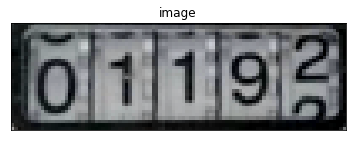

In [ ]:
dataset = WMRDataset(rec_args.train_dir, max_len=5, resize_shape=(rec_args.height, rec_args.width), train=True)
train_dataloader = data.DataLoader(dataset, batch_size=2, shuffle=True, pin_memory=True, drop_last=False)
batch = next(iter(train_dataloader))

image, label, label_len = batch
image = ((image[0].permute(1, 2, 0).to('cpu').numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
plt.title('image')
plt.xticks([])
plt.yticks([])
plt.imshow(image)
        
label_digit = label[0].to('cpu').numpy().tolist()
label_str = ''.join([dataset.id2char[t] for t in label_digit if t > 0])

print('label_digit: ', label_digit)
print('label_str: ', label_str)

In [ ]:
# backbone
class _Block(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(_Block, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        return out


class RecBackbone(nn.Module):
    def __init__(self):
        super(RecBackbone, self).__init__()
        
        in_channels = 3
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True))
        
        
        self.inplanes = 32
        self.layer1 = self._make_layer(32,  3, [2, 2]) # [16, 50]
        self.layer2 = self._make_layer(64,  4, [2, 2]) # [8, 25]
        self.layer3 = self._make_layer(128, 6, [2, 1]) # [4, 25]
        self.layer4 = self._make_layer(256, 6, [2, 1]) # [2, 25]
        self.layer5 = self._make_layer(512, 3, [2, 1]) # [1, 25]
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def _make_layer(self, planes, blocks, stride):
        downsample = None
        if stride != [1, 1] or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes))
            
        layers = []
        layers.append(_Block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(_Block(self.inplanes, planes))
            return nn.Sequential(*layers)
        
        
    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        
        cnn_feat = x5.squeeze(2) # [N, c, w]
        cnn_feat = cnn_feat.transpose(2, 1)
        
        return cnn_feat

# decoder
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn=512, nHidden=512, nOut=512):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
        
    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)    # [T * b, nOut]
        output = output.view(T, b, -1)
        
        return output

# basic
class RecModelBuilder(nn.Module):
    def __init__(self, rec_num_classes, sDim=512):
        super(RecModelBuilder, self).__init__()
        self.rec_num_classes = rec_num_classes
        self.sDim = sDim
        
        self.encoder = RecBackbone()
        self.decoder = nn.Sequential(
        BidirectionalLSTM(sDim, sDim, sDim),
        BidirectionalLSTM(sDim, sDim, rec_num_classes))
        
        self.rec_crit = nn.CTCLoss(zero_infinity=True)
        
    
    def forward(self, inputs):
        x, rec_targets, rec_lengths = inputs
        batch_size = x.shape[0]
        
        encoder_feats = self.encoder(x)   # N, T, C
        encoder_feats = encoder_feats.transpose(0, 1).contiguous() # T, N, C
        rec_pred = self.decoder(encoder_feats)
        
        if self.training:
            rec_pred = rec_pred.log_softmax(dim=2)
            preds_size = torch.IntTensor([rec_pred.size(0)] * batch_size)
            loss_rec = self.rec_crit(rec_pred, rec_targets, preds_size, rec_lengths)
            return loss_rec
        else:
            rec_pred_scores = torch.softmax(rec_pred.transpose(0, 1), dim=2)
            return rec_pred_scores

In [ ]:
'''
模型各阶段数据结构展示
'''
dataset = WMRDataset(rec_args.train_dir, max_len=rec_args.max_len, resize_shape=(rec_args.height, rec_args.width), train=True)
train_dataloader = data.DataLoader(dataset, batch_size=2, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
batch = next(iter(train_dataloader))

model = RecModelBuilder(rec_num_classes=rec_args.voc_size, sDim=rec_args.decoder_sdim)
model = model.to(device)
model.train()

image, rec_targets, rec_lengths = [v.to(device) for v in batch]
encoder_out = model.encoder(image)
decoder_out = model.decoder(encoder_out.transpose(0, 1).contiguous())
 

# batch 输入
print('batch 输入 [image, label, label_length]：')
print(batch[0].shape)
print(batch[1].shape)
print(batch[2].shape)
print()

# encoder 输出
print('encoder 输出：')
print(encoder_out.shape)
print()

# decoder 输出
print('decoder 输出：')
print(decoder_out.shape)

batch 输入 [image, label, label_length]：
torch.Size([2, 3, 32, 100])
torch.Size([2, 5])
torch.Size([2])

encoder 输出：
torch.Size([2, 25, 512])

decoder 输出：
torch.Size([25, 2, 21])


In [ ]:
# train
def rec_train():
    # dataset
    dataset = WMRDataset(rec_args.train_dir, max_len=rec_args.max_len, resize_shape=(rec_args.height, rec_args.width), train=True)
    train_dataloader = data.DataLoader(dataset, batch_size=rec_args.batch_size, num_workers=rec_args.num_workers, shuffle=True, pin_memory=True, drop_last=False)
    
    # model
    model = RecModelBuilder(rec_num_classes=rec_args.voc_size, sDim=rec_args.decoder_sdim)
    model = model.to(device)
    model.train()
    
    # Optimizer
    param_groups = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adadelta(param_groups, lr=rec_args.lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=rec_args.milestones, gamma=0.1)

    os.makedirs(rec_args.save_dir, exist_ok=True)
    # do train
    step = 2
    for epoch in range(rec_args.max_epoch):
        current_lr = optimizer.param_groups[0]['lr']
        
        for i, batch in enumerate(train_dataloader):
            step += 1
            batch = [v.to(device) for v in batch]
            loss = model(batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print
        if step % rec_args.print_interval == 0:
                print('step: {:4d}\tepoch: {:4d}\tloss: {:.4f}'.format(step, epoch, loss.item()))
        scheduler.step()
        
        # save
        save_name = 'checkpoint_' + str(epoch)
        torch.save(model.state_dict(), os.path.join(rec_args.save_dir, save_name))

    torch.save(model.state_dict(), rec_args.saved_model_path)

In [ ]:
# 运行训练代码
rec_train()

step:   50	epoch:    2	loss: 1.9379
step:  130	epoch:    7	loss: 1.6975
step:  210	epoch:   12	loss: 1.7950
step:  290	epoch:   17	loss: 1.7036
step:  370	epoch:   22	loss: 1.4804
step:  450	epoch:   27	loss: 1.0971
step:  530	epoch:   32	loss: 0.6519
step:  610	epoch:   37	loss: 0.4160
step:  690	epoch:   42	loss: 0.1216
step:  770	epoch:   47	loss: 0.0583
step:  850	epoch:   52	loss: 0.0380
step:  930	epoch:   57	loss: 0.0247
step: 1010	epoch:   62	loss: 0.0384
step: 1090	epoch:   67	loss: 0.0277
step: 1170	epoch:   72	loss: 0.0152
step: 1250	epoch:   77	loss: 0.0285
step: 1330	epoch:   82	loss: 0.0258
step: 1410	epoch:   87	loss: 0.0213
step: 1490	epoch:   92	loss: 0.0175
step: 1570	epoch:   97	loss: 0.0348


In [ ]:
'''
根据检测结果生成识别模型测试数据
'''
def rec_test_data_gen():
    test_dir = 'datasets/data/test_imgs'
    det_dir = 'temp/det_res'
    word_save_dir = 'temp/rec_datasets/test_imgs'

    os.makedirs(word_save_dir, exist_ok=True)
    label_files = os.listdir(det_dir)
    for label_file in tqdm(label_files):
        if not label_file.endswith('.txt'):
            continue
        with open(os.path.join(det_dir, label_file), 'r') as f:
            lines = f.readlines()
        if len(lines) == 0:
            continue
        line = lines[0].strip().split(',')
        locs = [float(t) for t in line[:8]]

        # image warp
        x1, y1, x2, y2, x3, y3, x4, y4 = locs
        w = int(0.5 * (((x2-x1)**2+(y2-y1)**2)**0.5 + ((x4-x3)**2+(y4-y3)**2)**0.5))
        h = int(0.5 * (((x2-x3)**2+(y2-y3)**2)**0.5 + ((x4-x1)**2+(y4-y1)**2)**0.5))
        src_points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype='float32')
        dst_points = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        image = cv2.imread(os.path.join(test_dir, label_file.replace('det_res_', '')[:-4] + '.jpg'))
        word_image = cv2.warpPerspective(image, M, (w, h))
        
        # save images
        cv2.imwrite(os.path.join(word_save_dir, label_file.replace('det_res_', '')[:-4]+'.jpg'), word_image)

# 使用检测模型获取识别测试数据
rec_test_data_gen()

100%|██████████| 501/501 [02:18<00:00,  3.61it/s]


In [ ]:
# inference
# 模型输出进行CTC对应解码，去除blank，将连续同字符合并
def rec_decode(rec_prob, labelmap, blank=0):
    raw_str = torch.max(rec_prob, dim=-1)[1].data.cpu().numpy()
    res_str = []
    for b in range(len(raw_str)):
        res_b = []
        prev = -1
        for ch in raw_str[b]:
            if ch == prev or ch == blank:
                prev = ch
                continue
            res_b.append(labelmap[ch])
            prev = ch
        res_str.append(''.join(res_b))
    return res_str
    
    
def rec_load_test_image(image_path, size=(100, 32)):
    img = Image.open(image_path)
    img = img.resize(size, Image.BILINEAR)
    img = torchvision.transforms.ToTensor()(img)
    img.sub_(0.5).div_(0.5)
    return img.unsqueeze(0)

# 测试
def rec_test():
    model = RecModelBuilder(rec_num_classes=rec_args.voc_size, sDim=rec_args.decoder_sdim)
    model.load_state_dict(torch.load(rec_args.saved_model_path, map_location=device))
    model.eval()
    
    os.makedirs(rec_args.rec_res_dir, exist_ok=True)
    _, _, labelmap = WMRDataset().gen_labelmap()          # labelmap是类别和字符对应的字典
    with torch.no_grad():
        for file in tqdm(os.listdir(rec_args.test_dir)):
            img_path = os.path.join(rec_args.test_dir, file)
            image = rec_load_test_image(img_path)
            batch = [image, None, None]
            pred_prob = model.forward(batch)
            # todo post precess
            rec_str = rec_decode(pred_prob, labelmap)[0]
            # write to file
            with open(os.path.join(rec_args.rec_res_dir, file.replace('.jpg', '.txt')), 'w') as f:
                f.write(rec_str)



In [ ]:
ls

sample_data/


In [ ]:
# 运行测试代码
rec_test()

In [ ]:
'''
识别结果后处理
'''
def final_postProcess():
    SPECIAL_CHARS = {k:v for k, v in zip('ABCDEFGHIJ', '1234567890')}

    test_dir = 'datasets/data/test_imgs'
    rec_res_dir = 'temp/rec_res'
    rec_res_files = os.listdir(rec_res_dir)

    final_res = dict()
    for file in os.listdir(test_dir):
        res_file = file.replace('.jpg', '.txt')
        if res_file not in rec_res_files:
            final_res[file] = ''
            continue
        
        with open(os.path.join(rec_res_dir, res_file), 'r') as f:
            rec_res = f.readline().strip()
        final_res[file] = ''.join([t if t not in 'ABCDEFGHIJ' else SPECIAL_CHARS[t] for t in rec_res])

    with open('work/final_res.txt', 'w') as f:
        for key, value in final_res.items():
            f.write(key + '\t' + value + '\n')


# 生成最终的测试结果
final_postProcess()